In [0]:
# Use GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 132681 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse -o nonempty drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import os
os.getcwd()
os.chdir('/content/drive/My Drive/')
os.getcwd()

'/content/drive/My Drive'

In [6]:
#import library
from glob import glob
import pandas as pd
import numpy as np
import fnmatch
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
x_sub=np.load('X_new.npy')
y_sub=np.load('Y_new.npy')
x_sub=x_sub[0:40000]
y_sub=y_sub[0:40000]

In [8]:
x_sub = np.array(x_sub)
x_sub_shape = x_sub.shape[1] * x_sub.shape[2] * x_sub.shape[3]
x_flat = x_sub.reshape(x_sub.shape[0], x_sub_shape)
r = pd.value_counts(y_sub)
print(r)

0    30556
1     9444
dtype: int64


In [9]:
rus=RandomUnderSampler(ratio='auto')
x_flat_resample,y_sub_resample=rus.fit_sample(x_flat,y_sub)
len(x_flat_resample)
r = pd.value_counts(y_sub_resample)
print(r)

1    9444
0    9444
dtype: int64


In [0]:
#split
from numpy import random
random.seed(1)
x_train,x_test,y_train,y_test=train_test_split(x_flat_resample,y_sub_resample,test_size=0.2)

In [11]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

15110
3778
15110
3778


In [0]:
#random forest
rf=RandomForestClassifier(n_estimators=20,max_depth=50,max_features='auto')
rf.fit(x_train,y_train)

In [0]:
test_prediction=rf.predict(x_test)
print(accuracy_score(y_test,test_prediction))
print(confusion_matrix(y_test,test_prediction))
print(metrics.classification_report(y_test,test_prediction))

In [0]:
#Tuning Parameter
test1={'n_estimators':range(10,100,10)}
grid_search1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,min_samples_leaf=20,max_depth=8,max_features='auto' ,random_state=20),param_grid =test1, scoring='roc_auc',cv=5)
grid_search1.fit(x_train,y_train)
grid_search1.best_params_
rf1=RandomForestClassifier(n_estimators=90,max_depth=8,min_samples_split=100,max_features='auto')
rf1.fit(x_train,y_train)
test_prediction1=rf1.predict(x_test)
print('accuracy_1:',accuracy_score(y_test,test_prediction1))

In [0]:
test2 = {'max_depth':range(50,201,50), 'min_samples_split':range(50,201,50)}
grid_search2= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 90,min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=20),param_grid=test2, scoring='roc_auc',iid=False, cv=5)
grid_search2.fit(x_train,y_train)
grid_search2.best_params_
rf2=RandomForestClassifier(n_estimators=90,max_depth=50,min_samples_split=50,max_features='auto')
rf2.fit(x_train,y_train)
test_prediction2=rf2.predict(x_test)
print('accuracy_2:',accuracy_score(y_test,test_prediction2))


In [0]:
test3={'min_samples_split':range(10,100,30), 'min_samples_leaf':range(10,100,30)}
grid_search3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 90, max_depth=50,max_features='auto' ,oob_score=True, random_state=20),param_grid =test3, scoring='roc_auc',iid=False, cv=5)
grid_search3.fit(x_train,y_train)
grid_search3.best_params_

In [12]:
rf3=RandomForestClassifier(n_estimators=90,max_depth=50,min_samples_split=10,min_samples_leaf=10,max_features='auto')
rf3.fit(x_train,y_train)
test_prediction3=rf3.predict(x_test)
print('accuracy_3:',accuracy_score(y_test,test_prediction3))
print(confusion_matrix(y_test,test_prediction3))
print(metrics.classification_report(y_test,test_prediction3))

accuracy_3: 0.8028057173107465
[[1493  397]
 [ 348 1540]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1890
           1       0.80      0.82      0.81      1888

    accuracy                           0.80      3778
   macro avg       0.80      0.80      0.80      3778
weighted avg       0.80      0.80      0.80      3778



In [0]:
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
import itertools
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
def plot_cm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_lc(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

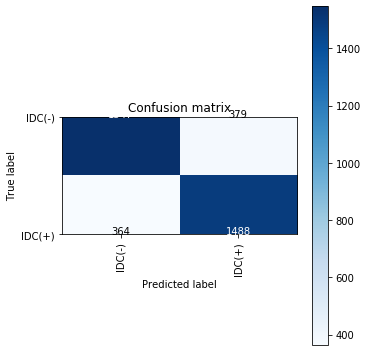

In [0]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
confusion_mtx = confusion_matrix(y_test, test_prediction3) 
plot_cm(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()
